<a href="https://colab.research.google.com/github/Misheal-22/Music-Genre-Classification/blob/main/Music_Genre_Classification_Description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: misheal22
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification


100%|██████████| 1.21G/1.21G [00:10<00:00, 122MB/s] 


In [15]:
DATA_PATH = "/content/gtzan-dataset-music-genre-classification/Data/genres_original"

In [17]:
def safe_load(file_path, target_sr=22050):
    try:
        # Try soundfile
        y, sr = sf.read(file_path, dtype='float32')
        if sr != target_sr:
            y = librosa.resample(y.T, orig_sr=sr, target_sr=target_sr)
        return y, target_sr
    except Exception:
        try:
            # Try librosa with ffmpeg backend
            y, sr = librosa.load(file_path, sr=target_sr, duration=30)
            return y, sr
        except Exception as e:
            print(f"[WARN] Could not load {file_path}: {e}")
            return None, None

def extract_features(file_path, n_mfcc=13):
    y, sr = safe_load(file_path)
    if y is None:
        return None
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    return np.hstack((mfccs_mean, mfccs_std))

genres = os.listdir(DATA_PATH)
features, labels = [], []

for g in genres:
    genre_path = os.path.join(DATA_PATH, g)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            feat = extract_features(file_path)
            if feat is not None:  # skip broken files
                features.append(feat)
                labels.append(g)

X = np.array(features)
y = np.array(labels)

/tmp/ipython-input-3917037947.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=target_sr, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


[WARN] Could not load /content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 


ENCODE LABELS

In [18]:
le = LabelEncoder()
y = le.fit_transform(y)


SPLIT

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


**SCALE**

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

TRAIN BASELINE MODEL

In [21]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

EVALUATION


=== RandomForest Results ===
              precision    recall  f1-score   support

       blues       0.81      0.65      0.72        20
   classical       0.87      1.00      0.93        20
     country       0.58      0.70      0.64        20
       disco       0.56      0.50      0.53        20
      hiphop       0.59      0.50      0.54        20
        jazz       0.84      0.80      0.82        20
       metal       0.74      0.70      0.72        20
         pop       0.71      0.85      0.77        20
      reggae       0.64      0.70      0.67        20
        rock       0.44      0.40      0.42        20

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



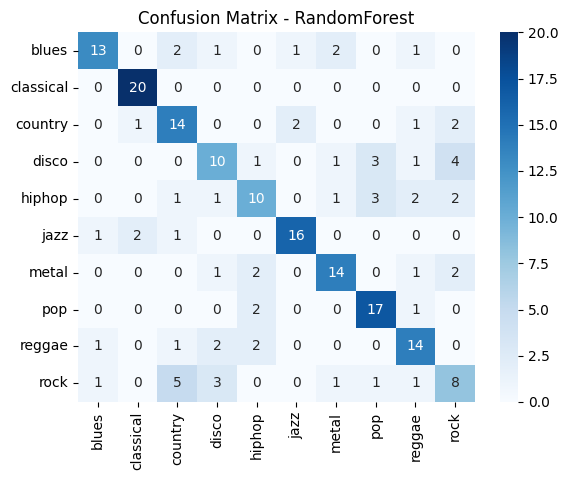

In [22]:
print("\n=== RandomForest Results ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest")
plt.show()